# Implementation of a comparison of uncalibrated scenario across all fairness functions

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid, mean_difference
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, log_cost_utility, demographic_parity, equal_opportunity
from src.plotting import plot_mean, plot_median
from src.training import train
from src.distribution import UncalibratedScore

unable to import 'smart_open.gcs', disabling that module


In [2]:
def calc_benefit(decisions, y, ips_weights):
    benefit = demographic_parity(decisions=decisions, y=y)

    if ips_weights is not None:
        benefit *= ips_weights

    return benefit

def fairness_gradient_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    benefit = calc_benefit(decisions, y, ips_weights)

    log_gradient = policy.log_policy_gradient(x, s)
    benefit_grad = log_gradient * benefit
        
    return mean_difference(benefit_grad, s)

def fairness_function(**fairness_kwargs):
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    benefit = calc_benefit(decisions, y, ips_weights)
        
    return mean_difference(benefit, s)

## Benefit Difference

In [5]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.142, **util_params)
    return util

training_parameters = {    
    'save_path': './',
    'model':{
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'fairness_gradient_function': fairness_gradient_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'learn_on_entire_history': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'initial_theta': [-3.0, 5.0]
    },
    'distribution': UncalibratedScore(bias=bias, fraction_protected=0.5),
    'parameter_optimization': {
        'time_steps':20,
        'epochs': 1,
        'batch_size':256,
        'num_batches': 128,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000,
        'fix_seeds': True
    },
    'test': {
        'num_samples': 8192
    }
}


In [6]:
training_parameters["experiment_name"] = "exp-010-uncalibrated-no-fairness"
training_parameters["model"]["initial_lambda"] = 0.0

statistics, _, run_path = train(training_parameters, iterations=10, asynchronous=True)

plot_mean(statistics, "{}/results_mean_time.png".format(run_path))
plot_median(statistics, "{}/results_median_time.png".format(run_path))

---------- Single training run for fixed lambda ----------


In [7]:
training_parameters["experiment_name"] = "exp-010-uncalibrated-benefit-lambda-sweep"
lambdas = np.logspace(-2, 1, base=10, endpoint=True, num=20)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])
training_parameters["model"]["initial_lambda"] = lambdas

statistics, model_parameters, run_path = train(training_parameters, iterations=5, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))

---------- Training with fixed lambdas ----------


In [5]:
training_parameters["experiment_name"] = "exp-010-uncalibrated-benefit-dual-gradient"
training_parameters["model"]["initial_lambda"] = 0.0
training_parameters["lagrangian_optimization"] = {
    'iterations': 20,
    'epochs': 10,
    'batch_size':256,
    'learning_rate': 0.1,
    'decay_rate': 1,
    'decay_step': 10000,
    'num_decisions': 128 * 256
}

statistics, model_parameters, run_path = train(training_parameters, iterations=5, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))

---------- Training both theta and lambda ----------


Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-16:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Process ForkPoolWorker-15:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-4:
Traceback (most recent call last):
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fkretschmar/miniconda3/envs/masters-thesis/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fkretschmar/miniconda3/envs/masters-thesis/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/fkretschmar/miniconda3/envs/masters-thesis/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
   

KeyboardInterrupt: 

## Covariance of decision

In [8]:
def calc_covariance(x, s, policy, ips_weights, decisions):    
    s_0_to_m1 = -(1 - s) 
    new_s = s + s_0_to_m1
    
    if ips_weights is not None:
        mu_s = np.mean(new_s * ips_weights, axis=0) 
        decisions *= ips_weights
    else:
        mu_s = np.mean(new_s, axis=0)

    covariance = (new_s - mu_s) * decisions
    return covariance

def fairness_gradient_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    ips_weights = fairness_kwargs["ips_weights"]
    decisions = fairness_kwargs["decisions"]
    
    covariance = calc_covariance(x, s, policy, ips_weights,decisions)

    log_policy_gradient = policy.log_policy_gradient(x, s)
    covariance_grad = log_policy_gradient * covariance

    return np.mean(covariance_grad, axis=0)

def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    ips_weights = fairness_kwargs["ips_weights"]
    decisions = fairness_kwargs["decisions"]
    
    covariance = calc_covariance(x, s, policy, ips_weights,decisions)
    return np.mean(covariance, axis=0)

bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.142, **util_params)
    return util

training_parameters = {    
    'save': True,
    'save_path': './',
    'model':{
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'fairness_gradient_function': fairness_gradient_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'learn_on_entire_history': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'initial_theta': [0.0, 0.0]
    },
    'parameter_optimization': {
        'time_steps':200,
        'epochs': 1,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000,
        'num_decisions': 128 * 256
    },
    'data': {
        'distribution': UncalibratedScore(bias=bias, fraction_protected=0.5),
        'num_test_samples': 8192
    }
}

---------- Training with fixed lambdas ----------


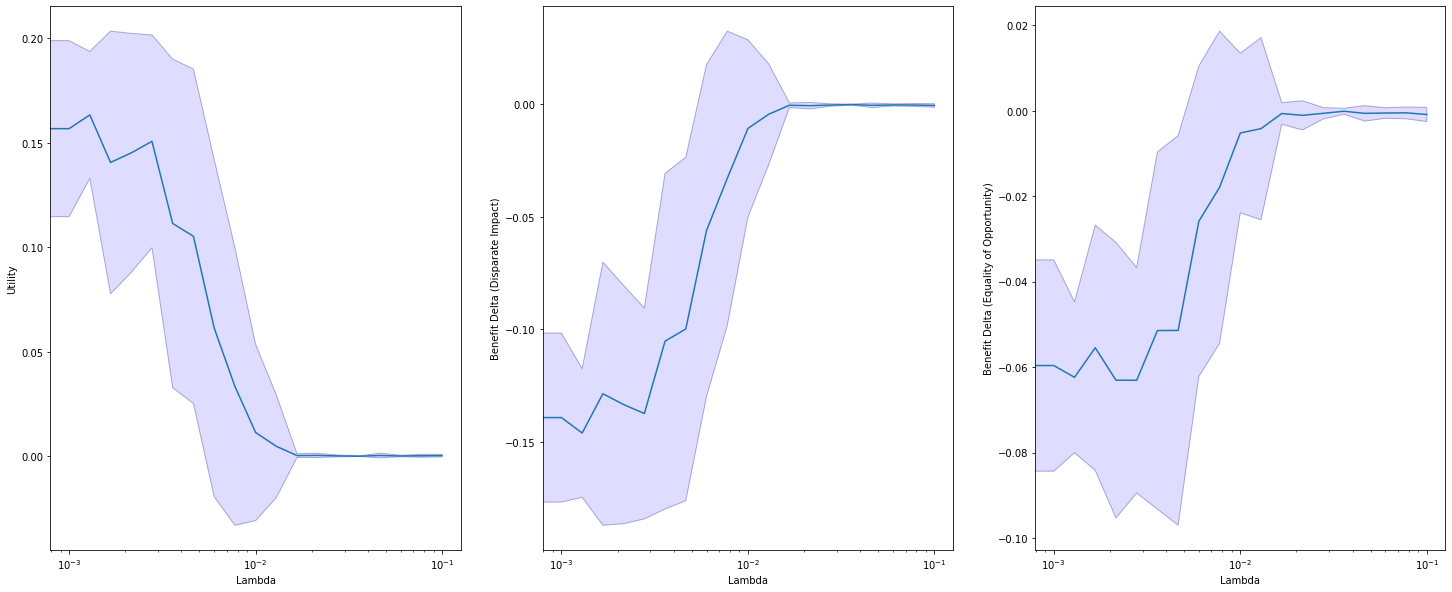

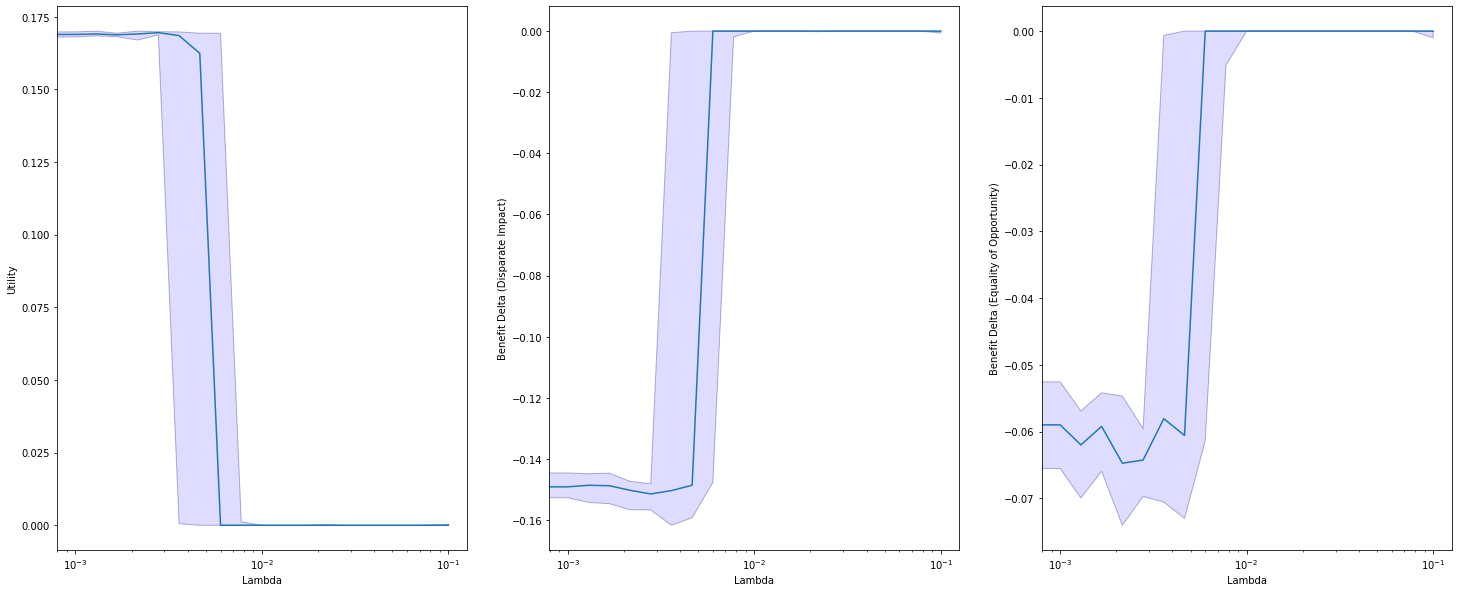

In [9]:
training_parameters["experiment_name"] = "exp-010-uncalibrated-covdecision-lambda-sweep"
lambdas = np.logspace(-3, -1, base=10, endpoint=True, num=19)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])
training_parameters["model"]["initial_lambda"] = lambdas

statistics, _, run_path = train(training_parameters, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))

---------- Training both theta and lambda ----------


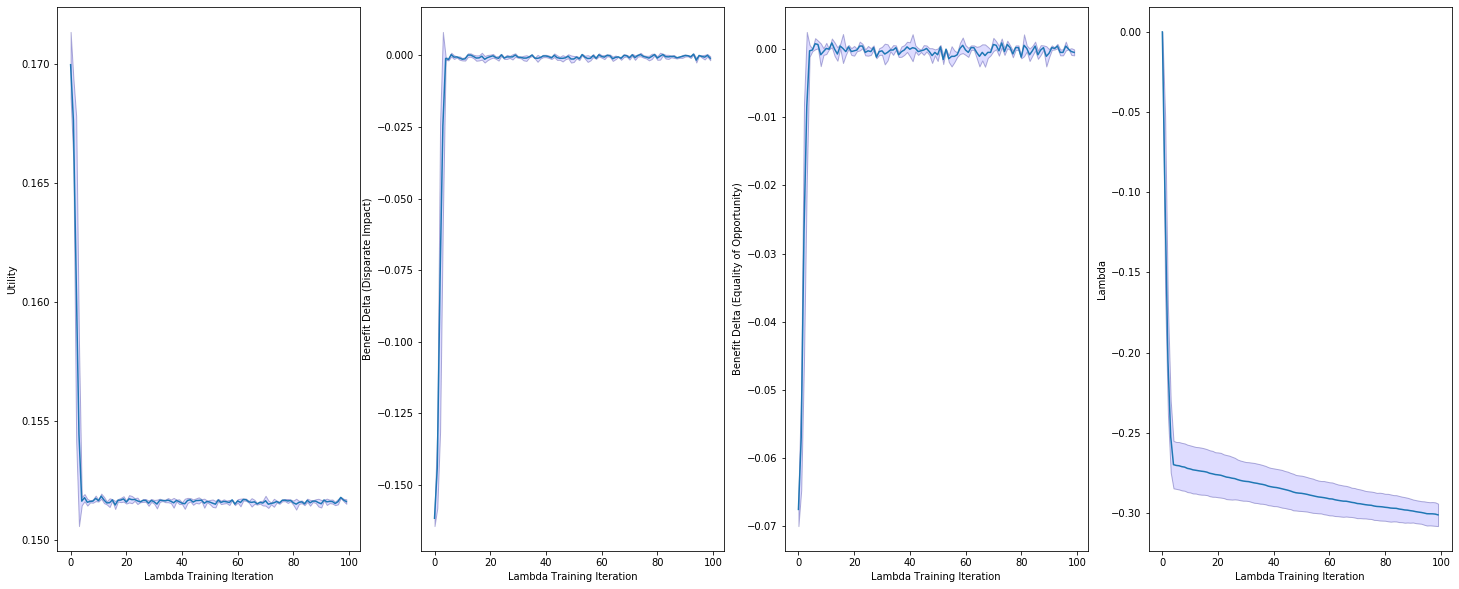

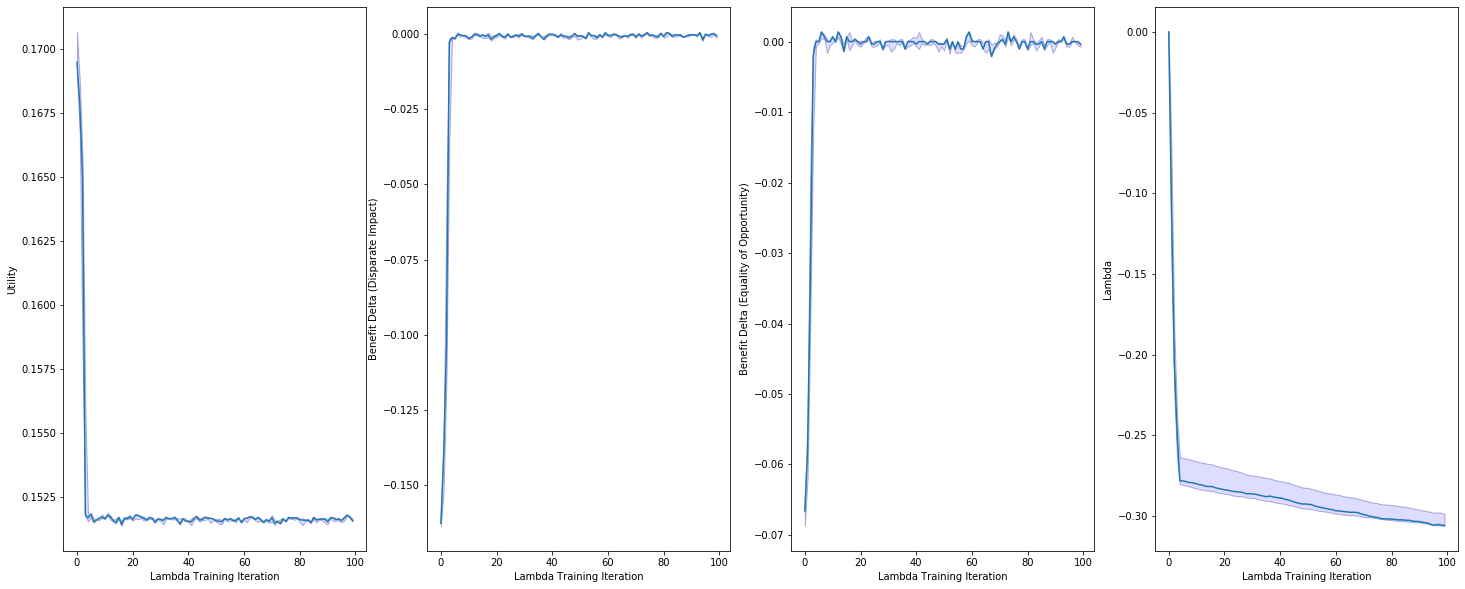

In [10]:
training_parameters["experiment_name"] = "exp-010-uncalibrated-covdecision-dual-gradient"
training_parameters["model"]["initial_lambda"] = 0.0
training_parameters["lagrangian_optimization"] = {
    'iterations': 100,
    'epochs': 1,
    'batch_size':256,
    'learning_rate': 0.01,
    'decay_rate': 1,
    'decay_step': 10000,
    'num_decisions': 128 * 256
}

statistics, model_parameters, run_path = train(training_parameters, iterations=3, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path), model_parameters=model_parameters)
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path), model_parameters=model_parameters)

## Covariance of distance

In [11]:
def calc_covariance(x, s, policy, ips_weights):    
    phi = policy.feature_map(policy._extract_features(x, s))
    distance = np.matmul(phi, policy.theta).reshape(-1, 1)
    
    if ips_weights is not None:
        mu_s = np.mean(s * ips_weights, axis=0)
        distance *= ips_weights
    else:
        mu_s = np.mean(s, axis=0)

    covariance = (s - mu_s) * distance
    return covariance, distance

def fairness_gradient_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    ips_weights = fairness_kwargs["ips_weights"]
    
    covariance, distance = calc_covariance(x, s, policy, ips_weights)

    log_policy_gradient = policy.log_policy_gradient(x, s)
    covariance_grad = log_policy_gradient * covariance

    return np.mean(covariance_grad, axis=0)

def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    ips_weights = fairness_kwargs["ips_weights"]
    
    covariance, distance = calc_covariance(x, s, policy, ips_weights)
    return np.mean(covariance, axis=0)

bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.142, **util_params)
    return util

training_parameters = {    
    'save': True,
    'save_path': './',
    'model':{
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'fairness_gradient_function': fairness_gradient_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'learn_on_entire_history': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'initial_theta': [0.0, 0.0]
    },
    'parameter_optimization': {
        'time_steps':200,
        'epochs': 1,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000,
        'num_decisions': 128 * 256
    },
    'data': {
        'distribution': UncalibratedScore(bias=bias, fraction_protected=0.5),
        'num_test_samples': 8192
    }
}


---------- Training both theta and lambda ----------


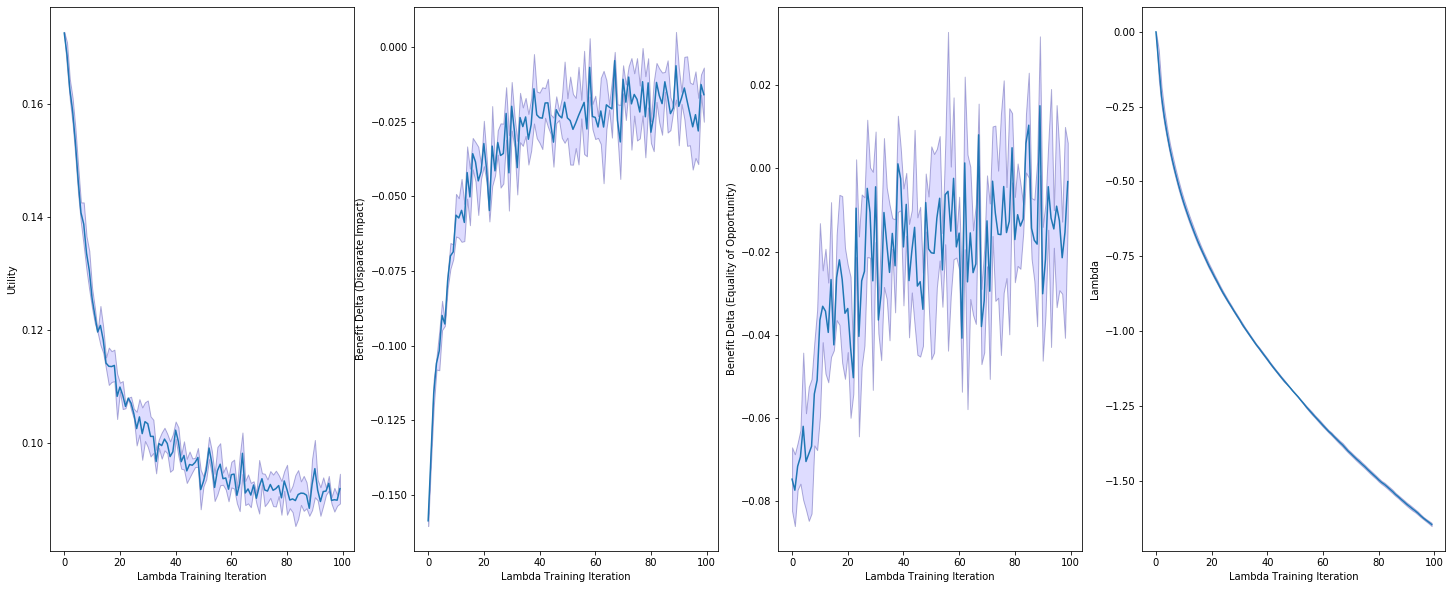

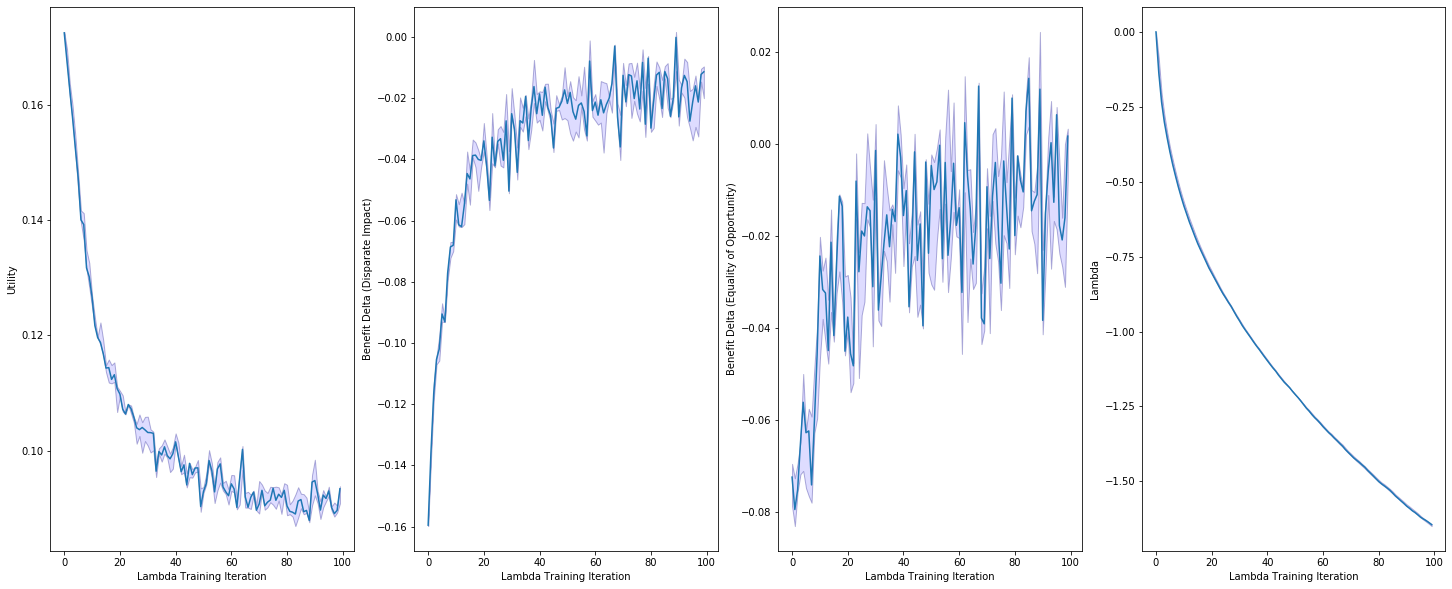

In [12]:
training_parameters["experiment_name"] = "exp-010-uncalibrated-covdistance-dual-gradient"
training_parameters["model"]["initial_lambda"] = 0.0
training_parameters["lagrangian_optimization"] = {
    'iterations': 100,
    'epochs': 1,
    'batch_size': 256,
    'learning_rate': 0.001,
    'decay_rate': 1,
    'decay_step': 10000,
    'num_decisions': 128 * 256
}

statistics, model_parameters, run_path = train(training_parameters, iterations=3, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path), model_parameters=model_parameters)
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path), model_parameters=model_parameters)

## Benefit difference (equality of opportunity)

In [3]:
def calc_benefit(decisions, y, ips_weights):
    if ips_weights is not None:
        decisions *= ips_weights

    return decisions

def fairness_gradient_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    benefit = calc_benefit(decisions, y, ips_weights)
    
    y1_indices = np.where(y = 1)

    log_gradient = policy.log_policy_gradient(x, s)
    benefit_grad = log_gradient * benefit
        
    return mean_difference(benefit_grad[y1_indices], s[y1_indices])

def fairness_function(**fairness_kwargs):
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    benefit = calc_benefit(decisions, y, ips_weights)
    
    y1_indices = np.where(y = 1)
        
    return mean_difference(benefit[y1_indices], s[y1_indices])

bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.142, **util_params)
    return util

training_parameters = {    
    'save': True,
    'save_path': './',
    'model':{
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'fairness_gradient_function': fairness_gradient_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'learn_on_entire_history': False,
        'use_sensitve_attributes': False,
        'bias': bias,
        'initial_theta': [0.0, 0.0]
    },
    'parameter_optimization': {
        'time_steps':200,
        'epochs': 1,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000,
        'num_decisions': 128 * 256
    },
    'data': {
        'distribution': UncalibratedScore(bias=bias, fraction_protected=0.5),
        'num_test_samples': 8192
    }
}

---------- Training with fixed lambdas ----------


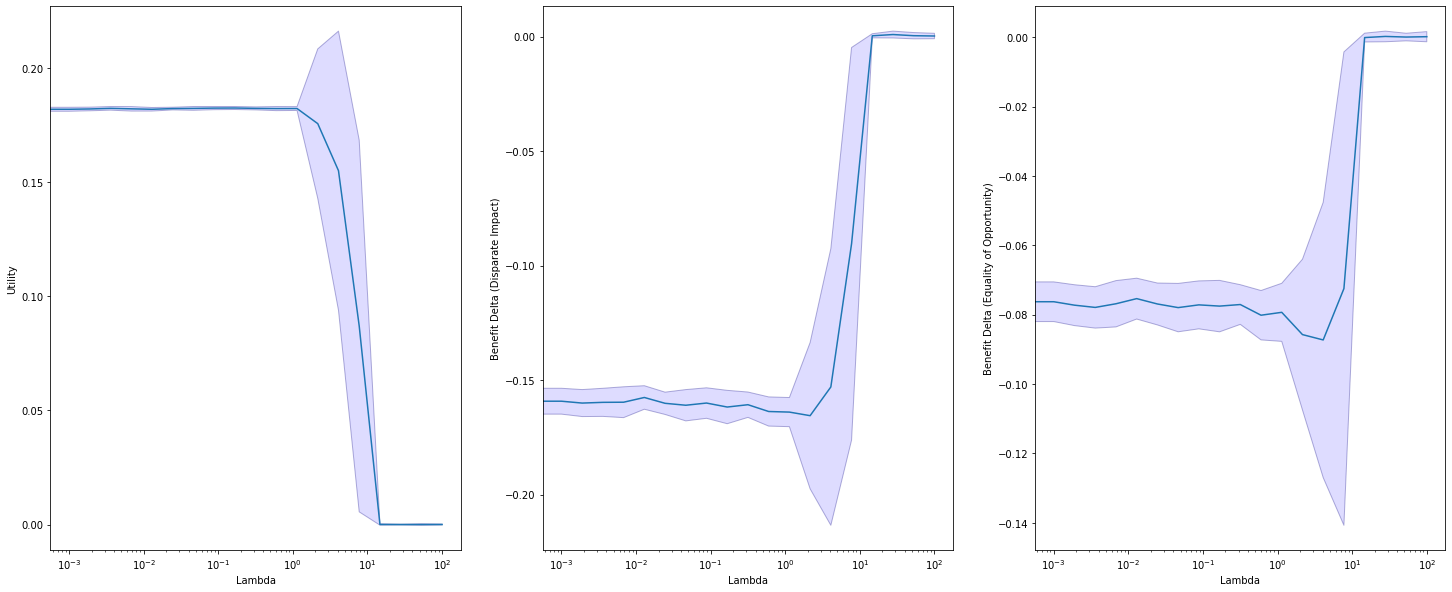

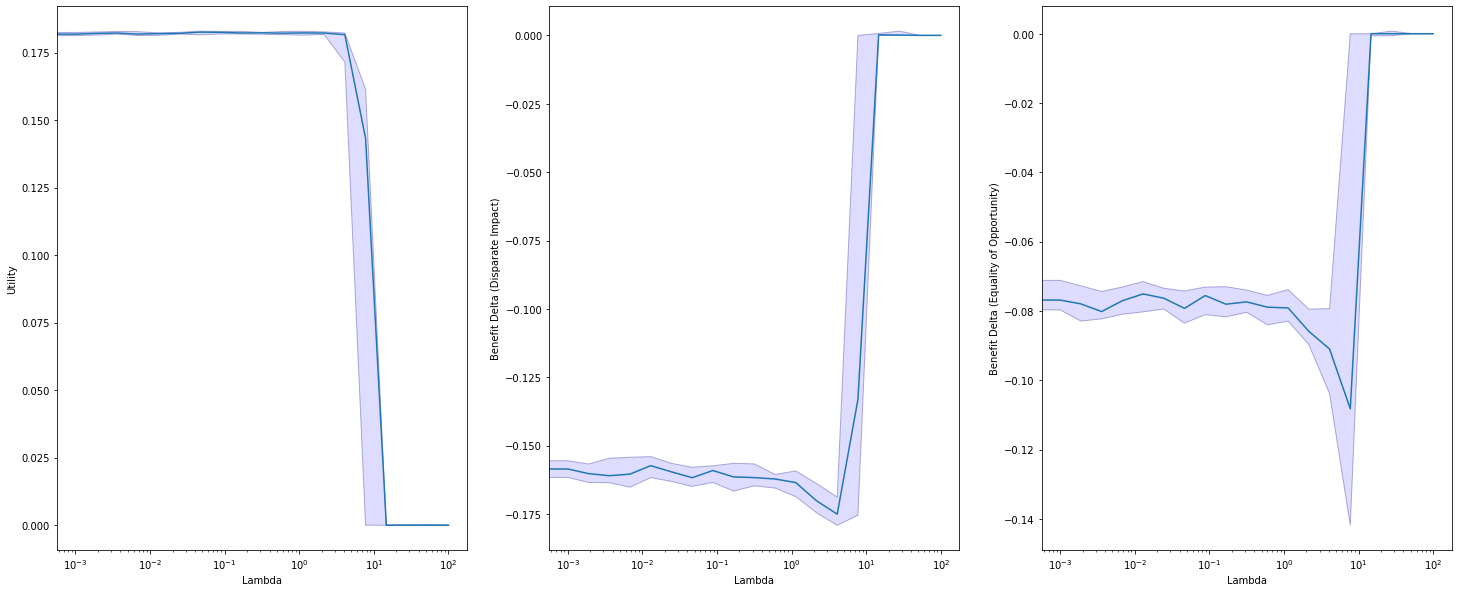

In [5]:
training_parameters["experiment_name"] = "exp-010-uncalibrated-benefit-lambda-sweep-eop"
lambdas = np.logspace(-3, 2, base=10, endpoint=True, num=19)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])
training_parameters["model"]["initial_lambda"] = lambdas

statistics, _, run_path = train(training_parameters, iterations=30, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path))

---------- Training both theta and lambda ----------


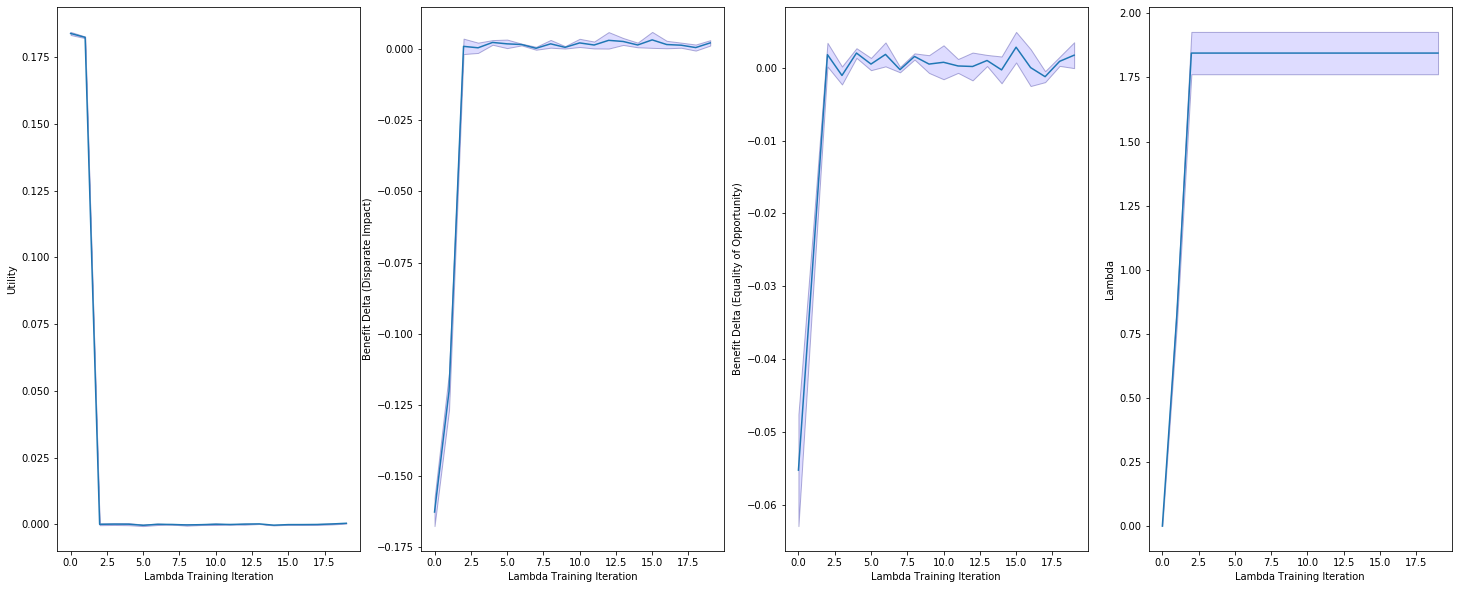

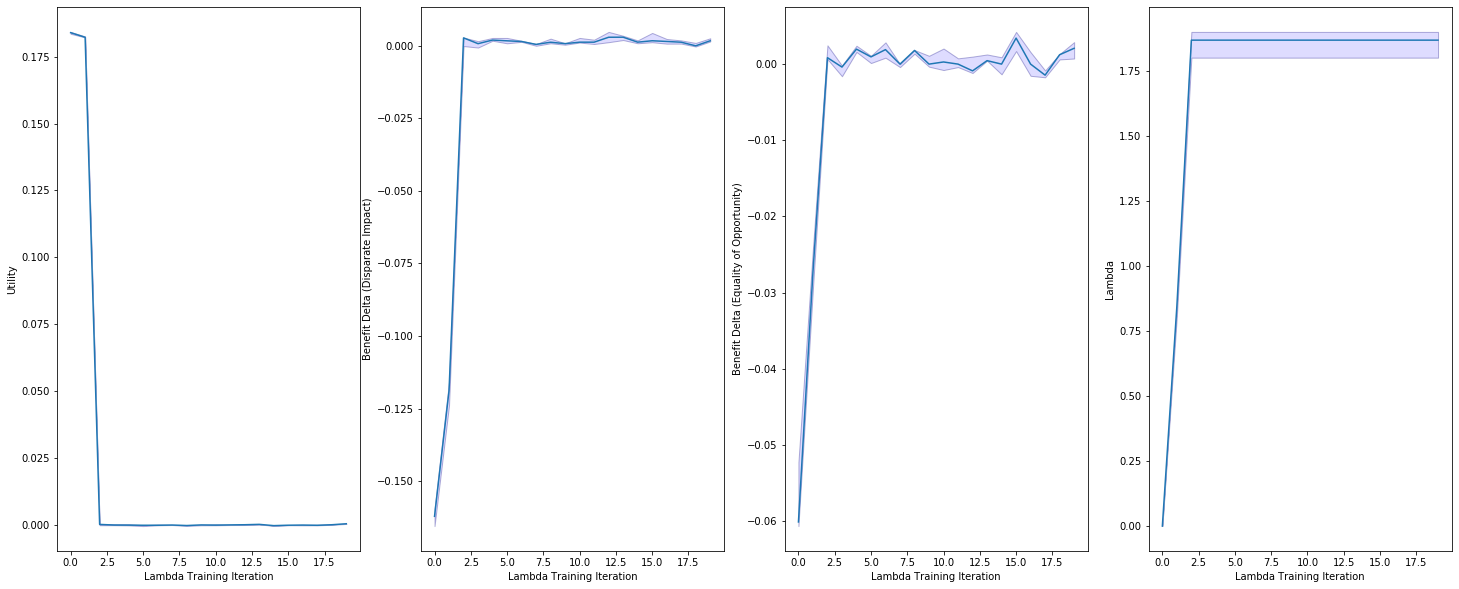

In [8]:
training_parameters["experiment_name"] = "exp-010-uncalibrated-benefit-dual-gradient-eop"
training_parameters["model"]["initial_lambda"] = 0.0
training_parameters["lagrangian_optimization"] = {
    'iterations': 20,
    'epochs': 10,
    'batch_size':256,
    'learning_rate': 0.01,
    'decay_rate': 1,
    'decay_step': 10000,
    'num_decisions': 128 * 256
}

statistics, model_parameters, run_path = train(training_parameters, iterations=3, asynchronous=True)

plot_mean(statistics, "{}/results_mean_lambdas.png".format(run_path), model_parameters=model_parameters)
plot_median(statistics, "{}/results_median_lambdas.png".format(run_path), model_parameters=model_parameters)